In [1]:
Sys.setenv("R_MAX_VSIZE" = 16e12)
memory.limit(size=16e12)
### Set working directory:
setwd("G:\\My Drive\\SDM_China\\")
#setwd("/export/home/mk843/mnt/")
### Load libraries
library(rstan)
library(rgdal)
library("bayesplot")
library("ggplot2")
library('grid') # For plotting with ggplot and grid
library('rethinking') # use this for the link function and generating predictions
library("maptools")
library("rgdal")
library("tidyr")
library("dplyr")
library("ggpubr")
library("cowplot")
library(raster) # for crs
library(ggbeeswarm)
library(tmap)
library(sf)

[1] 1.6e+13

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

For improved execution time, we recommend calling
Sys.setenv(LOCAL_CPPFLAGS = '-march=native')
although this causes Stan to throw an error on a few processors.

Loading required package: sp

rgdal: version: 1.4-8, (SVN revision 845)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: C:/Users/ycrnm/Documents/R/win-library/3.5/rgdal/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: C:/Users/ycrnm/Documents/R/win-library/3.5/rgdal/proj
 Linking to sp versi

In [3]:
mname<-'parabolic_simple_iCAR'
path2means<-paste('outputs/07_01_Future_means_',mname,".png",sep="")
path2predictions_plots <- paste('outputs/06_06_Posterior_Predictions_',mname,'.png',sep="")
path2locations<-"data/fagopyrum_east_asia.csv"
path2pred_summary <- paste('outputs/05_04_Predictions_summary_',mname,".csv",sep="")
path2boxplot<-paste('outputs/07_01_Boxplot_',mname,".png",sep="")
path2bplots<-paste('outputs/07_02_Blots_',mname,".png",sep="")
path2bplots_area<-paste('outputs/07_03_Blots_area',mname,".png",sep="")
path2min<-paste('outputs/07_02_Min_values_',mname,".csv",sep="")


In [4]:
# Input files:

#path2predictions <- paste('outputs/05_01_Posterior_Predi~ctions_',mname,'.csv',sep="")
path2prodData<-'data/china_data'

In [203]:
# Output files:
path2diffintTable<-('outputs/07_01_Predictions_errors_and_confidence_interval.csv')
path2diffintPlot<-('outputs/07_02_Predictions_errors_and_confidence_interval.png')
path2diffintPlotb<-('outputs/07_02B_Predictions_errors_and_confidence_interval_absolute_values.png')
path2checkMaps<-('outputs/07_03_Posterior_predictions_maps.png')
path2predMaps<-('outputs/07_03_Pas_predictions_maps.png')
path2niche_summary<-('outputs/07_05_Niche_summary.csv')

In [3]:
#predictions<-read.csv(path2pred_summary) # swap this for prediction summar in the boxplots:

In [7]:
### Fagopyrum locations for China:
#Import the table for Fagopyrum occurance records, based on (Hunt et al., 2017) and further evidence from the literature
locations <- read.csv(path2locations)
#locations <- read.csv(path2locations,fileEncoding="latin1")
# Trnsforma data into a spatial points data.frame
coordinates(locations)<-~longitude+latitude
locations<-subset(locations,Country=="China")

In [8]:
start=1500
loc<-subset(locations,end_date<=1500)
loc$period <- "1000 BP"
for (i in 1:5){
    sub<-subset(locations,(end_date<=start+1000 & end_date>start)| (start_date>start & start_date<=start+1000 ))
    start=start+1000
    print(paste(start-500,"BP",sep=" "))
    sub$period <- paste(start-500,"BP",sep=" ")
    loc<-rbind(loc,sub)
}

[1] "2000 BP"
[1] "3000 BP"
[1] "4000 BP"
[1] "5000 BP"
[1] "6000 BP"


In [7]:
#china<-readOGR(dsn = "data/china_predictions", layer = "china_predictions")

In [144]:
pred15k<-read.csv("outputs\\pred15k_summary.csv")

In [145]:
colnames(pred15k)<-paste(colnames(pred15k), "15k",sep="_")

In [146]:
head(pred15k)

,X_15k,X5._log_15k,X95._log_15k,means_pred_log_15k,X5._15k,X95._15k,means_pred_15k
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,county_pred,-11.81629,-8.756120,-12.74663,7.383283e-06,1.574946e-04,2.912129e-06
2,county_pred,-12.13150,-9.269684,-12.86364,5.387126e-06,9.423833e-05,2.590546e-06
3,county_pred,-11.32676,-8.343571,-11.46385,1.204624e-05,2.379213e-04,1.050298e-05
4,county_pred,-12.36516,-8.651430,-12.96728,4.264618e-06,1.748766e-04,2.335504e-06
5,county_pred,-11.69151,-8.437890,-11.27415,8.364494e-06,2.165064e-04,1.269699e-05
6,county_pred,-11.61993,-8.370090,-11.73187,8.985192e-06,2.316947e-04,8.033630e-06


In [9]:
predictions<-cbind(predictions,pred15k)

In [34]:
threshold<- -8.869086946

In [5]:
exp(threshold)

[1] 0.000140671

In [12]:
ls()

[1] "china_sf"               "i"                      "loc"                   
 [4] "locations"              "macros"                 "mname"                 
 [7] "outer"                  "path2boxplot"           "path2bplots"           
[10] "path2bplots_area"       "path2locations"         "path2means"            
[13] "path2min"               "path2pred_summary"      "path2predictions_plots"
[16] "periods"                "predictions"            "sb1"                   
[19] "sb2"                    "sb3"                    "sb4"                   
[22] "sb5"                    "sb6"                    "start"                 
[25] "sub"                    "threshold"

In [100]:
head(loc)

,No.,Sample_type,Quantity,Sediment_type_pollen_cores,Site_section_name,Site_short,Province,Country,Taxonomic_identification,Dating_method,Dating_result,Reference,lon,lat,altitude..masl.,location_source,start_date,end_date,period
,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<int>,<int>,<chr>
1,1,Pollen sequence,NA,Loess-palaeosol,Xindian section,Xindian,Shaanxi,China,Fagopyrum. sp,AMS 14C and OSL,from 5500 cal BP,Li et al. 2009,107°48'E,34°23'N,608.0,Li et al. 2009,5500,0,1000 BP
2,2,Pollen sequence,NA,Loess-palaeosol,Beizhuangcun section,Beizhuangcun,Shaanxi,China,Fagopyrum. sp,Stratigraphic comparison,from 5000 cal BP,Shang and Li 2010,109°32'E,34°21'N,519.0,Shang and Li 2010,5000,0,1000 BP
3,3,Pollen sequence,NA,Alluvial sediment,WangXianggou site,WangXianggou,Inner Mongolia,China,Fagopyrum. sp,AMS 14C,from 4700 cal BP,Li et al. 2006,119°55'E,42°04'N,751.0,Li et al. 2006,4700,0,1000 BP
4,4,Pollen sequence,NA,Loess-palaeosol with cultural layers,Xishanping site,Xishanping,Gansu,China,Fagopyrum. sp,AMS 14C,from 4600 cal BP,"Li et al. 2007, Cao et al 2019",105°32'41''E,34°33'50''N,1330.0,Li et al. 2007,4600,0,1000 BP
10,10,Pollen sequence,NA,Alluvial sediment,H9602,H9602,Shandong,China,Fagopyrum. sp,AMS 14C,1300 cal BP,Yi et al. 2003a,118°54.3'E,37°48.8'N,4.9,Yi et al. 2003a,1300,1300,1000 BP
11,11,Pollen sequence,NA,Alluvial sediment,Jinchuan site,Jinchuan,Jilin,China,Fagopyrum esculentum,AMS 14C,1100 cal BP,Makohonienko et al. 2008,126°22'E,42°20'N,665.0,Makohonienko et al. 2008,1100,1100,1000 BP


# Plotting past predictions with sf:



In [9]:
china<-readOGR(dsn = path2prodData, layer = "china_data")
pred_summary<-read.csv(path2pred_summary)

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\SDM_China\data\china_data", layer: "china_data"
with 2409 features
It has 36 fields


In [10]:
## Get the log means predictions, 0.05, and 0.95 quantiles for each county in a separate variables
mean_names<-colnames(pred_summary)[grepl("log",colnames(pred_summary))&grepl("means",colnames(pred_summary))]
means<-pred_summary[,colnames(pred_summary)[grepl("log",colnames(pred_summary))&grepl("means",colnames(pred_summary))]]
q5_names<-colnames(pred_summary)[grepl("log",colnames(pred_summary))&grepl("X5",colnames(pred_summary))]
q5<-pred_summary[,colnames(pred_summary)[grepl("log",colnames(pred_summary))&grepl("X5",colnames(pred_summary))]]
q95_names<-colnames(pred_summary)[grepl("log",colnames(pred_summary))&grepl("X95",colnames(pred_summary))]
q95<-pred_summary[,colnames(pred_summary)[grepl("log",colnames(pred_summary))&grepl("X95",colnames(pred_summary))]]

In [11]:
# Give the columns shorter names<
colnames(means)<-c("meanPred","pred1k","pred2k","pred3k","pred4k","pred5k","pred6k")
colnames(q95)<-c("log95","pred1k95","pred2k95","pred3k95","pred4k95","pred5k95","pred6k95")
colnames(q5)<-c("log5","pred1k5","pred2k5","pred3k5","pred4k5","pred5k5","pred6k5")

In [12]:
# Combine the predictions with the spatial polygons data frame of counties in china
china@data<-cbind(china@data,means,q5,q95)
# Calculate the predictions errod and the confidence interval size for each county in china@
china@data$difference<-china@data$meanPred - china@data$logArea
china@data$interval<-china@data$log95 - china@data$log5

In [13]:
### This bind the location data, with the predictions for counties in which buckwheat was found:
proj4string(loc) <- crs(china)
pred_data<-sp::over(loc,china)
loc@data<-cbind(loc@data,pred_data)

In [14]:
### The gets the mean predictions, 5th and 95th quantile for period to which each site is dated:
loc@data$mean<-NA
loc@data$q5<-NA
loc@data$q95<-NA

for (i in 1:6){
loc@data[grep(as.character(i),loc@data$period),c('mean','q5','q95')]<-loc@data[grep(as.character(i),loc@data$period),grep(paste(i,"k",sep=""),colnames(loc@data))]    }

In [15]:
threshold<-min(loc@data[loc@data$Site_section_name!="Kyung-lung Mesa/Kaerdong",]$mean,na.rm = TRUE)
threshold05<-min(loc@data[loc@data$Site_section_name!="Kyung-lung Mesa/Kaerdong",]$q5,na.rm = TRUE)
threshold95<-min(loc@data[loc@data$Site_section_name!="Kyung-lung Mesa/Kaerdong",]$q95,na.rm = TRUE)

In [198]:
threshold

[1] -8.869087

### Graphs of boxplots showing the confidence interval and diffrence between predictions and observations

In [346]:
# Get the summary statistics of difference between predictions and observations, and the confidence interval
dt<-summary(china@data$difference)
it<-summary(china@data$interval)
dt2<-summary(pred_summary$means_pred - china@data$AreaPr)
it2<-summary(pred_summary$X95. - pred_summary$X5.)
dstats<-as.data.frame(rbind(dt,it,dt2,it2))
dstats$statistics<-c("difference","interval","difference","interval")
dstats$scalse<-c("logarithmic scale","logarithmic scale","absolute valeus","absolute values")
rownames(dstats)<-NULL

In [363]:
write.csv(dstats, file=path2diffintTable,row.names = FALSE)

In [12]:
di<-gather(china@data[,c('difference','interval')], key = "stat",value="value")

In [146]:
dip<-ggplot(di, aes(x=stat,y=value)) + 
  geom_violin(data=di, aes(x=stat,y=value),lwd=0.2,color="grey50")+
  geom_boxplot(width=0.1,fill="tan2",outlier.size=0.4,lwd=0.3)+
  theme_classic()+ 
  theme(panel.grid.major.y = element_line(color="grey90",size=0.2),
      axis.title=element_text(size=7,face="plain"),
      axis.text=element_text(size=7))+
  labs(y="log proportion of area under buckwheat cultivation\n",x="")+
  scale_x_discrete(labels=c("\ndifference between the\nmean predictions and the observed values","\nsize of the 90%\nconfidence interval"))+
  scale_y_continuous(breaks=seq(-10,20,2))

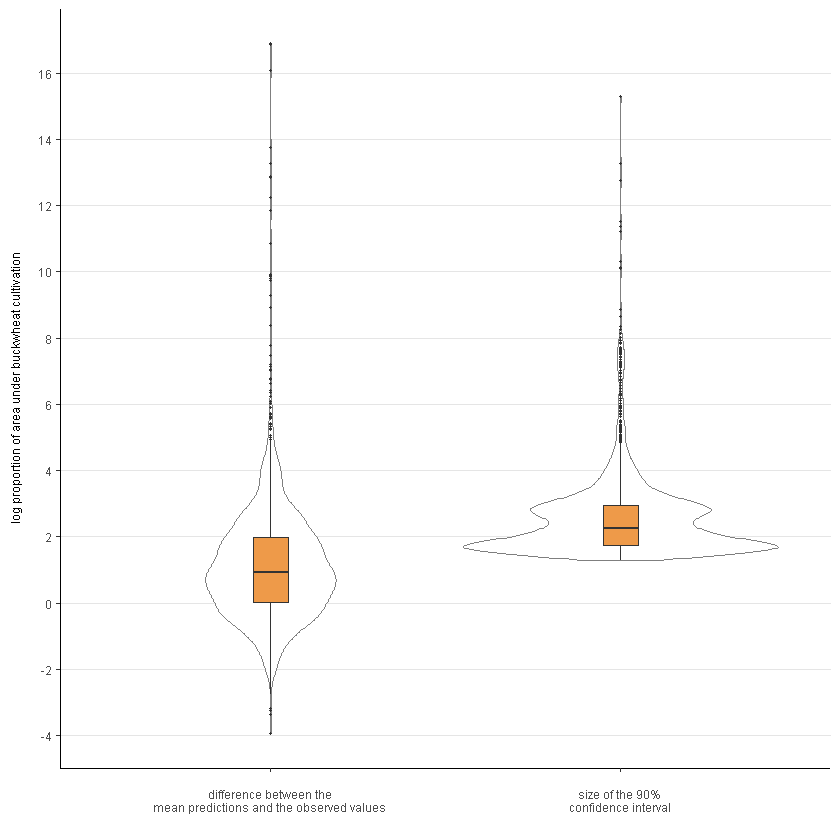

In [147]:
height=21/2
width=21/2
ggsave(path2diffint,dip,width = width, height = height, units = "cm",device='png',dpi = 600)
dip

In [149]:
### The same for the unlogged difference:
china@data$difference<-pred_summary$means_pred - china@data$AreaPr
china@data$interval<-pred_summary$X95. - pred_summary$X5.

In [289]:
di_exp<-gather(china@data[,c('difference','interval')], key = "stat",value="value")

In [324]:
dip_exp_all<-ggplot(di_exp, aes(x=stat,y=value)) + 
  geom_violin(data=di_exp, aes(x=stat,y=value),lwd=0.2,color="grey50")+
  geom_boxplot(width=0.1,fill="tan2",outlier.size=0.4,lwd=0.3)+
  theme_classic()+ 
  theme(panel.grid.major.y = element_line(color="grey90",size=0.2),
      axis.title=element_text(size=7,face="plain"),
      axis.text=element_text(size=7))+
  labs(y="proportion of area under buckwheat cultivation\n",x="")+
  scale_x_discrete(labels=c("\ndifference between the\nmean predictions and the observed values","\nsize of the 90%\nconfidence interval"))

In [316]:
dip_exp_zoom<-ggplot(di_exp, aes(x=stat,y=value)) + 
  geom_violin(data=di_exp, aes(x=stat,y=value),lwd=0.2,color="grey50")+
  geom_boxplot(width=0.1,fill="tan2",outlier.size=0.4,lwd=0.3)+
  theme_classic()+ 
  theme(panel.grid.major.y = element_line(color="grey90",size=0.2),
      axis.title=element_text(size=7,face="plain"),
      axis.text=element_text(size=7))+
  labs(y="proportion of area under buckwheat cultivation\n",x="")+
  scale_x_discrete(labels=c("\ndifference between the\nmean predictions and the observed values","\nsize of the 90%\nconfidence interval"))+
 scale_y_continuous(limits=c(-0.03,0.1),expand=c(0,0))

In [325]:
dip_exp<-ggarrange(dip_exp_all,dip_exp_zoom,ncol=2)

Warning message:
"Removed 107 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 107 rows containing non-finite values (stat_boxplot)."


In [326]:
height=21/2
width=21
ggsave(path2diffintb,dip_exp,width = width, height = height, units = "cm",device='png',dpi = 600)

In [328]:
# Check in how many counties the observed values fall within the 90% confidence interval
table(china@data$meanPred>china@data$log5 & china@data$meanPred<china@data$log95)


TRUE 
2409 

## Poserior predictions maps

In [68]:
mp<-as_Spatial(st_union(china_sf[china_sf$meanPred>=threshold,]))
mp<-SpatialPolygonsDataFrame(mp,data=data.frame(id=3,quantile="Mean Predictions",row.names=row.names(mp)))

la<-as_Spatial(st_union(china_sf[china_sf$logArea>=threshold,]))
la<-SpatialPolygonsDataFrame(la,data=data.frame(id=1,quantile="Mean Predictions",row.names=row.names(la)))

q05p<-as_Spatial(st_union(china_sf[china_sf$log5>=threshold05,]))
q05p<-SpatialPolygonsDataFrame(q05p,data=data.frame(id=4,quantile="5th Quantile",row.names=row.names(q05p)))

q95p<-as_Spatial(st_union(china_sf[china_sf$log95>=threshold95,]))
q95p<-SpatialPolygonsDataFrame(q95p,data=data.frame(id=2,quantile="95th Quantile",row.names=row.names(q95p)))

inner_border<-rbind(la,q95p,mp,q05p)

In [17]:
china_sf<-st_as_sf(china) 
outer_border<-st_union(china_sf)
&&sf_object[as.data.frame(sf_object[,column])[,1]<=threshold_max[1],])

In [242]:
get_borders<-function(columns,threshold_min,threshold_max,facets,sf_object){
    if(is.null(threshold_min)){threshold_min=-Inf} # If min is not given set it to  -infinity
    if(is.null(threshold_max)){threshold_max=Inf} # Id max is not given set it to infinity 
    if(is.null(facets)){facets=columns}
    column<-columns[1]
    facet<-facets[1]
    sb<-as_Spatial(st_union(sf_object[as.data.frame(sf_object[,column])[,1]>=threshold_min[1] && as.data.frame(sf_object[,column])[,1]>=threshold_max[1] ,]))
    sb<-SpatialPolygonsDataFrame(sb,data=data.frame(id=1,facet=facet,row.names=row.names(sb)))
    borders<-sb
    for (i in 2:6){
        column<-columns[i]
        facet<-facets[i]
        if(length(threshold_min)>1){t_min=threshold_min[i]}else{t_min=threshold_min}
        if(length(threshold_max)>1){t_max=threshold_max[i]}else{t_max=threshold_max}
        sb<-as_Spatial(st_union(sf_object[as.data.frame(sf_object[,column])[,1]>=t_min && as.data.frame(sf_object[,column])[,1]>=t_max[1],]))
        sb<-SpatialPolygonsDataFrame(sb,data=data.frame(id=i,facet=facet,row.names=row.names(sb)))
        borders<-rbind(borders,sb)
    }
    return(borders)
}

In [221]:
threshold[1]

[1] -8.869087

In [19]:
facets<-unique(loc@data$period)

In [162]:
inner_border95<-get_borders(colnames(q95)[2:7], threshold95,facets, sf_object=china_sf)

In [163]:
inner_border5<-get_borders(colnames(q5)[2:7], threshold05,facets, sf_object=china_sf)

In [40]:
inner_border_pred<-get_borders(colnames(means)[2:7],threshold,facets,sf_object=china_sf)

In [20]:
#Define the labels:
columns<-c("pred1k","pred2k","pred3k","pred4k","pred5k","pred6k","logArea","log95","meanPred","log5")
labels<-c("A: OBSERVED VALUES", "B: PREDICTIONS AT 95TH PERCENTILE","C: MEAN PREDICTIONS","D: PREDICTIONS AT 5TH PERCENTILE")

# Breaks and labels for the unlog transformation of the predictions:
n<-c(0.000000001,0.0000001,0.00001,0.001,1)
breaks<-c(min(china@data$log5),log(n),max(china@data$log95))
tickmarks<-c("",n,"")

# Breaks and labels for the interval and difference:
n2<-c(0.01,1,100,10000)
breaks2<-c(log(n2),max(china@data$difference))
tickmarks2<-c(n2,"")

In [69]:
check_maps<-tm_shape(china) +
    # Define the colors of the polygons and the legend
    tm_fill(col=columns[7:10], title.col="Period",style="cont",n=20,legend.reverse = TRUE,palette="-RdYlBu",title = "log area\nfraction\nunder\nbuckwheat\ncultivation",showNA = F,midpoint=NA)+
    # Define the facets to draw:
    tm_facets(free.scales=FALSE,free.coords=FALSE,ncol = 2,nrow = 2)+   
    # Add the outer border to the plot
    tm_shape(outer_border)+
    tm_borders(col="grey75",lwd=0.5)+
    # Add the shape of the predicted niche  
    tm_shape(inner_border)+
    tm_borders(col="grey1",lwd=0.8,lty="dashed")+
    tm_facets(by = "id",free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=2)+
    # Format layout:
    tm_layout(panel.labels=labels,
              panel.label.bg.color="white",
              frame=FALSE,
              legend.outside.size=0.08,
              legend.outside = TRUE,
              legend.text.size = 0.7,
              panel.label.size = 1.2,
              panel.label.fontface = "bold",
              legend.title.size=1,
              frame.lwd = NA,
             panel.label.height=2)

Variable(s) "difference", "interval" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.



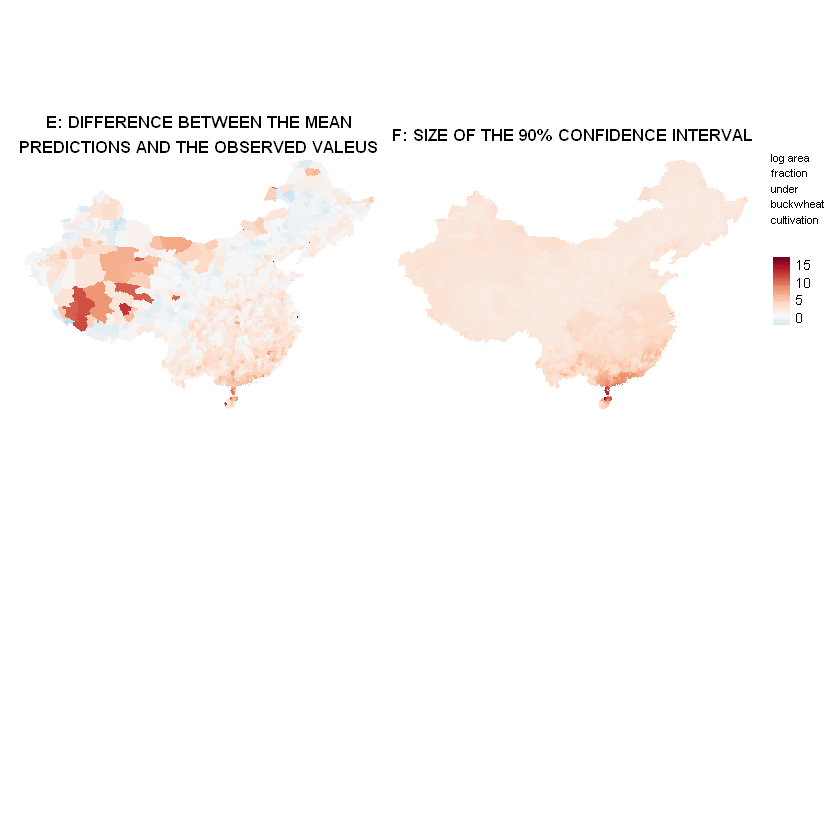

In [205]:
# Repeat the maps twice, to keep them to scale
diff_maps<-tm_shape(china)+
tm_fill(col=c("difference","interval"), title.col="Period",style = "cont",legend.reverse = TRUE,palette=c("-RdBu"),title = c("log area\nfraction\nunder\nbuckwheat\ncultivation"),showNA = F)+
    tm_layout(panel.labels=c("E: DIFFERENCE BETWEEN THE MEAN\nPREDICTIONS AND THE OBSERVED VALEUS","F: SIZE OF THE 90% CONFIDENCE INTERVAL" ),
              panel.label.bg.color="white",
              frame=FALSE,
              legend.outside.size=0.08,
              legend.outside = TRUE,
              legend.text.size = 0.7,
              panel.label.size = 1.2,
              panel.label.fontface = "bold",
              legend.title.size=1,
              frame.lwd = NA,
              panel.label.height=2)+
    tm_facets(free.scales=FALSE,nrow=2,ncol=2)

In [211]:
diag_maps<-tmap_arrange(check_maps,diff_maps)

In [212]:
width=21
height=29.7
tmap_save(
  tm = diag_maps,
  filename = path2checkMaps,
  width = width,
  height = height,
  units = "cm",
  dpi = 500)

Variable(s) "difference", "interval" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.

Variable(s) "difference", "interval" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.

Map saved to G:\My Drive\SDM_China\outputs\07_03_Posterior_predictions_maps.png

Resolution: 4133.858 by 5846.457 pixels

Size: 8.267717 by 11.69291 inches (500 dpi)



In [24]:
pred_labels<-unique(loc@data$period)

In [30]:
macros<-loc
macros$Sample_type<-as.character(macros$Sample_type)
macros[macros$Site_section_name=="Kyung-lung Mesa/Kaerdong",'Sample_type']<-c("F. tataricum charrded seeds","F. tataricum charrded seeds")

In [32]:
a<-tm_shape(macros)+
    tm_symbols(col ="Sample_type", shape="Sample_type",size=0.6,legend.col.show=FALSE,legend.shape.show=FALSE,palette=c("mediumorchid3","red","mediumseagreen","mediumvioletred"),shapes = c(17,4,16,15))+
    tm_facets(by = "period",free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=3)

In [41]:
head(inner_border_pred)

,id,facet
,<dbl>,<fct>
ID1,1,1000 BP
ID11,2,2000 BP
ID12,3,3000 BP
ID13,4,4000 BP
ID14,5,5000 BP
ID15,6,6000 BP


In [42]:
a<-tm_shape(inner_border_pred)+
    tm_borders(col="grey1",lwd=0.5,lty="dashed")+
    tm_facets(by = "id",free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=3)

In [80]:
seq(-26,6,2)

[1] -26 -24 -22 -20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6

In [108]:
pred_maps<-tm_shape(china) +
    # Define the colors of the polygons and the legend
    tm_fill(col=columns[1:6], title.col="Period",style="cont",breaks=seq(-26,6,2),legend.reverse = TRUE,palette="-RdYlBu",title = "log area\nfraction\nunder\nbuckwheat\ncultivation",showNA = F,midpoint=NA)+
    # Define the facets to draw:
    tm_facets(free.scales=FALSE,free.coords=FALSE,ncol = 2,nrow = 3)+   
    # Add the outer border to the plot
    tm_shape(outer_border)+
    tm_borders(col="grey75",lwd=0.5)+
    # Add the shape of the predicted mean niche  
    tm_shape(inner_border_pred)+
    tm_borders(col="grey1",lwd=0.5,lty="dashed")+
    tm_facets(by = "id",free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=3)+
    # Add the location of macro and microfossils to the map
    tm_shape(macros)+
    tm_symbols(col ="Sample_type", shape="Sample_type",size=0.6,legend.col.show=FALSE,legend.shape.show=FALSE,palette=c("mediumorchid4","red","mediumseagreen","slateblue1"),shapes = c(17,4,16,15))+
    tm_facets(by = "period",free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=3)+
    # Add legend with symbols for different types of macros
    # Add the shape of the pedicted 95 confidence interval
    #tm_shape(inner_border95)+
    #tm_borders(col="mediumspringgreen",lwd=0.5,lty="dashed")+
    #tm_facets(by = "id",free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=3)+ 
    # Add the shape of the pedicted 55 confidence interval
    #tm_shape(inner_border5)+
    #tm_borders(col="slateblue1",lwd=0.5,lty="dashed")+
    #tm_facets(by = "id",free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=3)+ 
    # Format layout:
    tm_layout(panel.labels=pred_labels,
              panel.label.bg.color="white",
              frame=FALSE,
              legend.outside.size=0.08,
              legend.outside = TRUE,
              legend.text.size = 0.7,
              panel.label.size = 1.2,
              panel.label.fontface = "bold",
              legend.title.size=1,
              frame.lwd = NA,
              panel.label.height=2,
              legend.width=0.3)+
    tm_add_legend("symbol",shape=c(17,17,17,16,17,15,17,4,17), col = c("white","mediumorchid4","white","mediumseagreen","white","slateblue1","white","red","white"), size = c(0.8,0.8,0.8,0.8),labels = str_wrap(c("","charred seeds","","pollen","","starch","","F.tataricum charred seeds",""),width=12))              

In [94]:
library(stringr)

Warning message in preprocess_gt(x, interactive = interactive, orig_crs = gm$shape.orig_crs):
"legend.width controls the width of the legend within a map. Please use legend.outside.size to control the width of the outside legend"
Warning message:
"Values have found that are less than the lowest break"
Some legend labels were too wide. These labels have been resized to 0.44, 0.50, 0.50, 0.30. Increase legend.width (argument of tm_layout) to make the legend wider and therefore the labels larger.



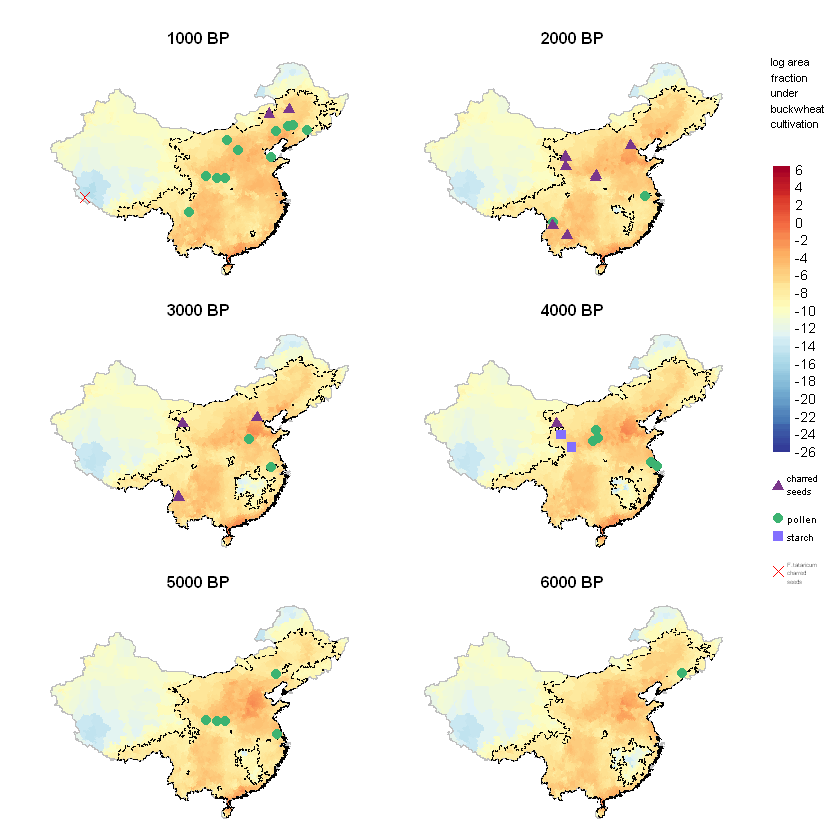

In [101]:
pred_maps

In [109]:
width=21
height=29.7*0.75
tmap_save(
  tm = pred_maps,
  filename = path2predMaps,
  width = width,
  height = height,
  units = "cm",
  dpi = 500)

Warning message in preprocess_gt(x, interactive = interactive, orig_crs = gm$shape.orig_crs):
"legend.width controls the width of the legend within a map. Please use legend.outside.size to control the width of the outside legend"
Warning message:
"Values have found that are less than the lowest break"
Some legend labels were too wide. These labels have been resized to 0.65, 0.44. Increase legend.width (argument of tm_layout) to make the legend wider and therefore the labels larger.

Map saved to G:\My Drive\SDM_China\outputs\07_03_Pas_predictions_maps.png

Resolution: 4133.858 by 4384.843 pixels

Size: 8.267717 by 8.769685 inches (500 dpi)



In [117]:
china_frag<-china[,columns[1:6]]

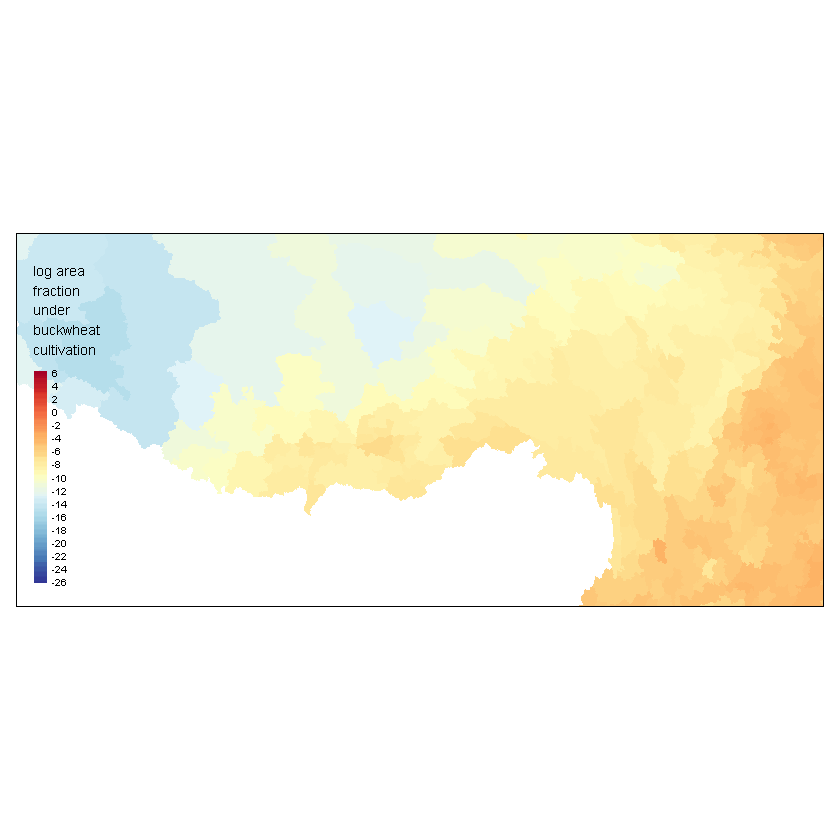

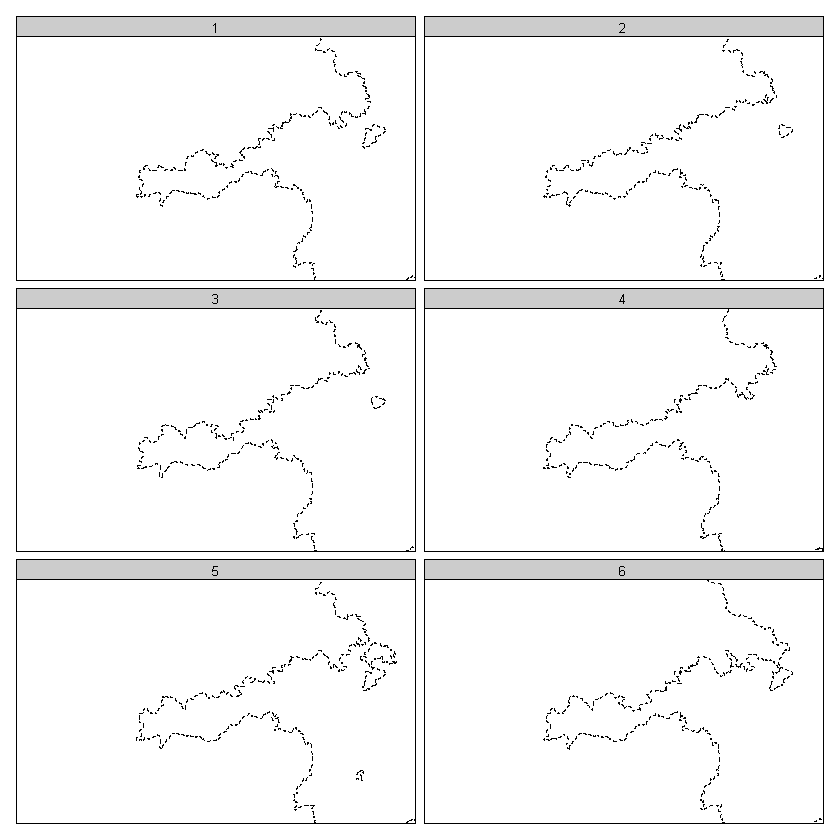

In [130]:
### Need to put the elevation on the background for the Himalayas
tm_shape(china_frag,bbox=raster::extent(list(x=c(80,105), y=c(25,35)))) +
    # Define the colors of the polygons and the legend
    tm_fill(col=columns[1], title.col="Period",style="cont",breaks=seq(-26,6,2),legend.reverse = TRUE,palette="-RdYlBu",title = "log area\nfraction\nunder\nbuckwheat\ncultivation",showNA = F,midpoint=NA)
    tm_shape(inner_border_pred,bbox=raster::extent(list(x=c(80,105), y=c(25,35))))+
    tm_borders(col="grey1",lwd=0.5,lty="dashed")+
    tm_facets(by = "id",free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=3)

In [126]:
raster::extent(list(x=c(-90,-105), y=c(25,30)))

class      : Extent 
xmin       : -105 
xmax       : -90 
ymin       : 25 
ymax       : 30 

In [125]:
extent(china)

class      : Extent 
xmin       : 73.5577 
xmax       : 134.7739 
ymin       : 18.15931 
ymax       : 53.56086 

Warning message:
"Values have found that are less than the lowest break"


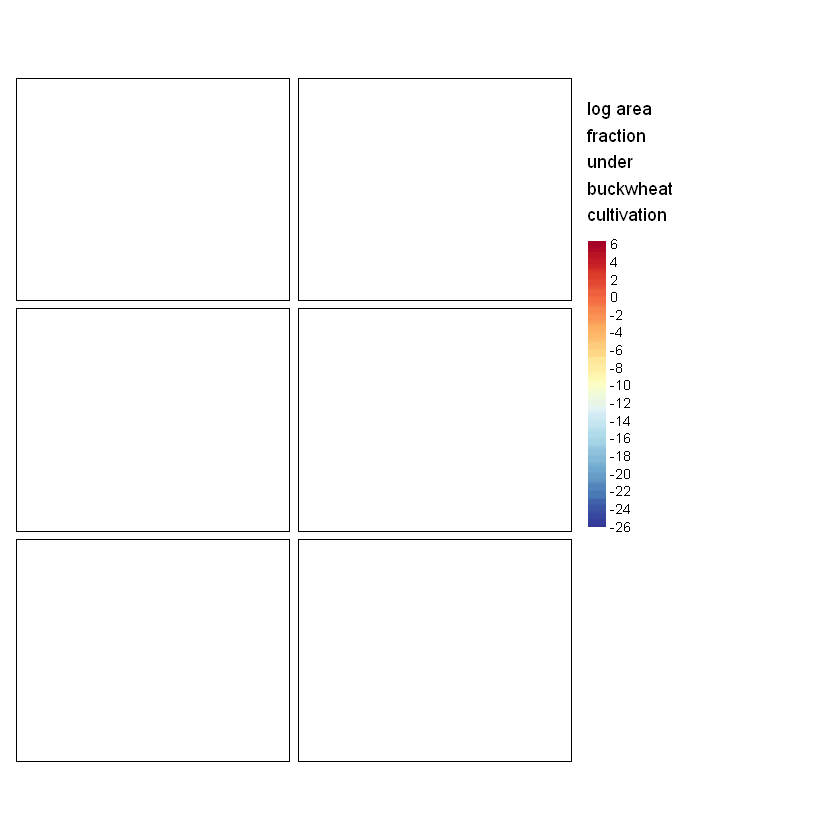

In [121]:
frag_maps<-tm_shape(china_frag,bbox=extent(list(x=c(80,105), y=c(25,35)))) +
    # Define the colors of the polygons and the legend
    tm_fill(col=columns[1:6], title.col="Period",style="cont",breaks=seq(-26,6,2),legend.reverse = TRUE,palette="-RdYlBu",title = "log area\nfraction\nunder\nbuckwheat\ncultivation",showNA = F,midpoint=NA)+
    tm_facets(free.scales=FALSE,free.coords=FALSE,ncol = 2,nrow = 3)
frag_maps

#  Minimu predictor values within the niches

In [189]:
### Get pred by Period, and after that get all the counties where the predictions are above the threshold, for each period
### Then get the predictor values for each period in those counties, and get their ranges
colnames(china@data)

[1] "ID_0"       "ISO"        "NAME_0"     "ID_1"       "NAME_1"    
 [6] "ID_2"       "NAME_2"     "ID_3"       "NAME_3"     "TYPE_3"    
[11] "ENGTYPE_3"  "NL_NAME_3"  "VARNAME_3"  "BIO10"      "BIO17"     
[16] "BIO4"       "BIO9"       "npp"        "BIO10_sd"   "BIO17_sd"  
[21] "BIO4_sd"    "BIO9_sd"    "npp_sd"     "AreaDQ"     "YieldDQ"   
[26] "AreaFr"     "AreaHaS"    "AreaHaM"    "ProdSum"    "ProdMean"  
[31] "YieldPH"    "area"       "AreaPr"     "ProdHa"     "logArea"   
[36] "logProd"    "meanPred"   "pred1k"     "pred2k"     "pred3k"    
[41] "pred4k"     "pred5k"     "pred6k"     "log5"       "pred1k5"   
[46] "pred2k5"    "pred3k5"    "pred4k5"    "pred5k5"    "pred6k5"   
[51] "log95"      "pred1k95"   "pred2k95"   "pred3k95"   "pred4k95"  
[56] "pred5k95"   "pred6k95"   "difference" "interval"

In [195]:
china<-readOGR(dsn = "data/china_data", layer = "china_data")

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\SDM_China\data\china_data", layer: "china_data"
with 2409 features
It has 36 fields


In [197]:
colnames(china@data)

[1] "ID_0"      "ISO"       "NAME_0"    "ID_1"      "NAME_1"    "ID_2"     
 [7] "NAME_2"    "ID_3"      "NAME_3"    "TYPE_3"    "ENGTYPE_3" "NL_NAME_3"
[13] "VARNAME_3" "BIO10"     "BIO17"     "BIO4"      "BIO9"      "npp"      
[19] "BIO10_sd"  "BIO17_sd"  "BIO4_sd"   "BIO9_sd"   "npp_sd"    "AreaDQ"   
[25] "YieldDQ"   "AreaFr"    "AreaHaS"   "AreaHaM"   "ProdSum"   "ProdMean" 
[31] "YieldPH"   "area"      "AreaPr"    "ProdHa"    "logArea"   "logProd"

In [190]:
data<-china@data[grep(paste("_",i,"_",sep=""),colnames(china@data))]

In [194]:
grep(paste("_",1,"_",sep=""),colnames(china@data))

integer(0)

In [201]:
paste(c("BIO4","BIO9","BIO1","BIO17","npp"),"_",i,sep="")

[1] "BIO4_8"  "BIO9_8"  "BIO1_8"  "BIO17_8" "npp_8"

In [199]:
pred_niche<-subset(predByPeriod,predictions>=threshold)
p_niche<-pred_niche[,c('period','predictions')]
p_niche[,c("BIO4","BIO9","BIO10","BIO17","npp")]<-NA

p_niche[p_niche$period=="present",c("BIO4","BIO9","BIO10","BIO17","npp")]<-pred_niche[pred_niche$period=="present",c("BIO4","BIO9","BIO1","BIO17","npp")]

for(i in 2:length(unique(p_niche$period))){
    print(i)
    period<-unique(p_niche$period)[i]
    p_niche[p_niche$period==period,c("BIO4","BIO9","BIO10","BIO17","npp")]<-pred_niche[pred_niche$period==period,paste(c("BIO4","BIO9","BIO10","BIO17","npp"),"_",i-1,sep="")]

}

In [ ]:
niche_summary<-apply(p_niche[3:7],2, summary)

In [ ]:
write.csv(niche_summary, path2niche_summary)

In [205]:
niche_summary<-read.csv(path2niche_summary,row.names=1)

In [218]:
apply(niche_summary,2,min)

BIO4       BIO9      BIO10      BIO17        npp 
293.940065 -21.500691   5.016294   0.000000  85.890044

In [244]:
sf_object<-china_sf

In [ ]:
sf_object[as.data.frame(sf_object[,column])[,1]

In [ ]:
get_borders<-function(columns,threshold_min,threshold_max,facets,sf_object){
    if(is.null(threshold_min)){threshold_min=-Inf} # If min is not given set it to  -infinity
    if(is.null(threshold_max)){threshold_max=Inf} # Id max is not given set it to infinity 
    if(is.null(facets)){facets=columns}
    column<-columns[1]
    facet<-facets[1]
    sb<-as_Spatial(st_union(sf_object[as.data.frame(sf_object[,column])[,1]>=threshold_min[1] && as.data.frame(sf_object[,column])[,1]>=threshold_max[1] ,]))
    sb<-SpatialPolygonsDataFrame(sb,data=data.frame(id=1,facet=facet,row.names=row.names(sb)))
    borders<-sb
    for (i in 2:6){
        column<-columns[i]
        facet<-facets[i]
        if(length(threshold_min)>1){t_min=threshold_min[i]}else{t_min=threshold_min}
        if(length(threshold_max)>1){t_max=threshold_max[i]}else{t_max=threshold_max}
        sb<-as_Spatial(st_union(sf_object[as.data.frame(sf_object[,column])[,1]>=t_min && as.data.frame(sf_object[,column])[,1]>=t_max[1],]))
        sb<-SpatialPolygonsDataFrame(sb,data=data.frame(id=i,facet=facet,row.names=row.names(sb)))
        borders<-rbind(borders,sb)
    }
    return(borders)
}

In [243]:
var_borders<-get_borders(colnames(niche_summary),as.numeric(niche_summary["Min.",]),as.numeric(niche_summary["Max.",]),colnames(niche_summary),sf_object=china_sf)

ERROR: Error in st_cast_sfc_default(x): list item(s) not of class sfg


# Past mean predictions:

In [148]:
### Add data from 15k
pred<-cbind(china@data,pred15k)

In [170]:
# Gather data by period
predByPeriod <- gather(pred,period,predictions,c(colnames(means),"means_pred_15k"))

In [172]:
### Change names to more informative ones
p1<-c("present",unique(loc@data$period),"15 0000 BP")
p2<-unique(predByPeriod$period)
for (i in 1: length(p1)){predByPeriod$period[predByPeriod$period==p2[i]]<-p1[i]}

In [181]:
### Scale predictions by the size of the county
predByPeriodScaled<-data.frame()
for (i in 1: length(p2)){
    a<-as.data.frame(cbind(predByPeriod$predictions[predByPeriod$period==p1[i]],china@data$area/1e+6))
    colnames(a)<-c("predictions","freq")
    count <- as.data.table(rep(a$predictions,a$freq),ncol=1,byrow=TRUE)
    count$period<-p1[i]
    colnames(count)<-c("Predictions","Period")
    predByPeriodScaled<-rbind(predByPeriodScaled,count)
}

In [184]:
d3<-predByPeriodScaled

In [186]:
beeswarmv2<-ggplot()+
    geom_violin(data=d3, aes(x=Period, y=exp(Predictions)-1e-11),col="darkgrey")+
    geom_hline(aes(yintercept = exp(threshold),linetype="minimum predicted value\n for sites where buckwheat\nremains were found"),colour="lightblue",size=1)+
    #geom_beeswarm(data=d1[d1$Site_section_name!="Kyung-lung Mesa/Kaerdong",], aes(x=period, y=exp(mean)-1e-11,colour=Sample_type),cex=3.5)+
    #geom_beeswarm(data=d1[d1$Site_section_name=="Kyung-lung Mesa/Kaerdong",][1,], aes(x=period, y=exp(mean)-1e-11,fill="Site_section_name"),colour="red",cex=3.5)+
    scale_colour_manual(name="",values=c("lightgreen","cornflowerblue","darkviolet"))+
    scale_linetype_manual(name = "",values="dashed")+
    scale_fill_manual(name="",values="red",labels="F. tataricum\ncharred seed")+
    theme_bw()+
scale_y_continuous(trans='log2',breaks=c(1e-10,1e-7,1e-4,1e-1))+
    #scale_fill_manual(name="Sites with\nbuckwheat",values=c("darkgreen"),labels=c(""))+
    labs(y = "PREDICTED VALUE\n(proportion of the area under buckehwat cultivation)\n",title="DISTRIBUTION OF ARCHAEOLOGICAL SITES WITH BUCKWEHAT REMAINS IN ENVIRONMENTAL SPACE")+
    theme_bw()+
    theme(axis.text.x = element_text(face="bold", size=14),
         axis.text.y = element_text(face="bold", size=14),
         axis.title.x=element_blank(),
         axis.title.y=element_blank(),
         plot.title = element_text(size=16),
         legend.position="bottom",
         legend.title = element_text(size = 16),
         legend.text = element_text(size = 13),
         legend.key.width = unit(2,"cm")) +
            guides(colour = guide_legend(override.aes = list(size=2)),
                   linetype = guide_legend(override.aes = list(size=1.5)))

Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 2663 rows containing non-finite values (stat_ydensity)."


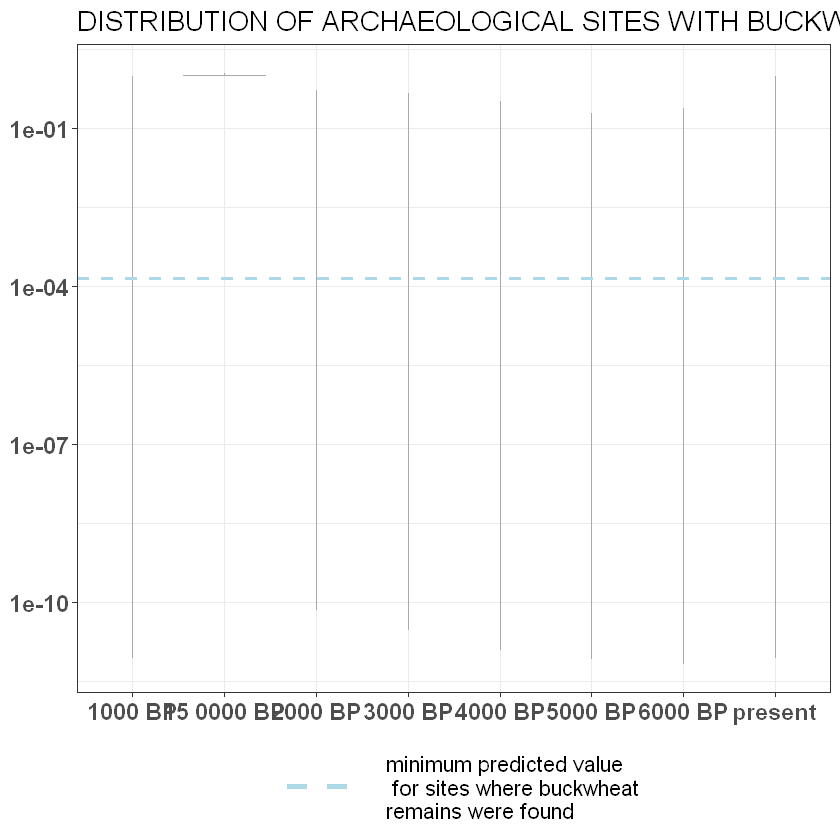

In [187]:
beeswarmv2

In [ ]:
#dev.off()
#width=5
#height=5
#dev.new(width=width, height=height, unit="in")
boxplot<-ggplot()+
  #geom_boxplot(data=d1, aes(x=period, y=predictions,fill=factor(interval,levels=c("q5","q95","mean"))),show.legend=TRUE,position = "identity",alpha=0.1)+
  #scale_fill_manual(name="interval",values=c("darkblue","darkgreen","darkgrey"),labels=c("5 %","95%","mean"))+
  #scale_alpha(range = c(0.1, 1))+
  geom_boxplot(data=loc@data, aes(x=period, y=mean),color="black",fill="darkgrey",alpha=0.95)+
  labs(title = "Suitability of environmental conditions on the sites\nwhere buckwheat was found")+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5,size=10))

In [94]:
beeswarmv<-ggplot()+
    geom_violin(data=d2, aes(x=period, y=exp(predictions)-1e-11),col="darkgrey")+
    geom_hline(aes(yintercept = exp(threshold),linetype="minimum predicted value\n for sites where buckwheat\nremains were found"),colour="lightblue",size=1)+
    geom_beeswarm(data=d1[d1$Site_section_name!="Kyung-lung Mesa/Kaerdong",], aes(x=period, y=exp(mean)-1e-11,colour=Sample_type),cex=2)+
    geom_beeswarm(data=d1[d1$Site_section_name=="Kyung-lung Mesa/Kaerdong",][1,], aes(x=period, y=exp(mean)-1e-11,fill="Site_section_name"),colour="red",cex=2)+
    scale_colour_manual(name="",values=c("black","orange","green"))+
    scale_linetype_manual(name = "",values="dashed")+
    scale_fill_manual(name="",values="red",labels="F. tataricum\ncharred seeds")+
    #scale_fill_manual(name="Sites with\nbuckwheat",values=c("darkgreen"),labels=c(""))+
    theme_bw()+
scale_y_continuous(trans='log2',breaks=c(1e-10,1e-7,1e-4,1e-1))+
    #scale_fill_manual(name="Sites with\nbuckwheat",values=c("darkgreen"),labels=c(""))+
    labs(y = "PREDICTED VALUE\n(proportion of the area under buckehwat cultivation)\n",title="VIOLIN PLOT")+
    theme_bw()+
    theme(axis.text.x = element_text(face="bold", size=14),
         axis.text.y = element_blank(),
         axis.title.x=element_blank(),
         axis.title.y=element_blank(),
         plot.title = element_text(size=16),
         legend.position="bottom",
         legend.title = element_text(size = 16),
         legend.text = element_text(size = 14),
         legend.key.width = unit(2,"cm")) +
            guides(colour = guide_legend(override.aes = list(size=2)),
                   linetype = guide_legend(override.aes = list(size=1.5)))

In [96]:
beeswarmb<-ggplot()+
    geom_boxplot(data=d2, aes(x=period, y=exp(predictions)-1e-11),col="darkgrey")+
    geom_hline(aes(yintercept = exp(threshold),linetype="minimum predicted value\n for sites where buckwheat\nremains were found"),colour="lightblue",size=1)+
    geom_beeswarm(data=d1[d1$Site_section_name!="Kyung-lung Mesa/Kaerdong",], aes(x=period, y=exp(mean)-1e-11,colour=Sample_type),cex=2)+
    geom_beeswarm(data=d1[d1$Site_section_name=="Kyung-lung Mesa/Kaerdong",][1,], aes(x=period, y=exp(mean)-1e-11,fill="Site_section_name"),colour="red",cex=2)+
    scale_colour_manual(name="",values=c("black","orange","green"))+
    scale_linetype_manual(name = "",values="dashed")+
    scale_fill_manual(name="",values="red",labels="F. tataricum\ncharred seed")+
    #scale_fill_manual(name="Sites with\nbuckwheat",values=c("darkgreen"),labels=c(""))+
    theme_bw()+
scale_y_continuous(trans='log2',breaks=c(1e-10,1e-7,1e-4,1e-1))+
    #scale_fill_manual(name="Sites with\nbuckwheat",values=c("darkgreen"),labels=c(""))+
    labs(y = "PREDICTED VALUE\n(proportion of the area under buckehwat cultivation)\n",title="BOX PLOT")+
    theme_bw()+
    theme(axis.text.x = element_text(face="bold", size=14),
         axis.text.y = element_text(face="bold", size=14),
         axis.title.x=element_blank(),
         axis.title.y=element_blank(),
         plot.title = element_text(size=16),
         legend.position="bottom",
         legend.title = element_text(size = 16),
         legend.text = element_text(size = 14),
         legend.key.width = unit(2,"cm")) +
            guides(colour = guide_legend(override.aes = list(size=2)),
                   linetype = guide_legend(override.aes = list(size=1.5)))

In [ ]:
head(d1)

In [ ]:
ggplot()+ 
geom_beeswarm(data=d1, aes(x=period, y=exp(mean)-1e-11, color=Sample_type),cex=2)

In [ ]:
ggplot()+
geom_hline(yintercept = exp(min_values['6000 BP','mean']),linetype="dashed", color = "lightblue", size=1)+
 scale_linetype_manual(name = "limit", values=exp(min_values['6000 BP','mean']), 
                      guide = guide_legend(override.aes = list(color ="blue")))+
theme(legend.position = "left")

In [ ]:
saved <- options(repr.plot.width=20, repr.plot.height=8)
saved$repr.plot.width <- 20
saved$repr.plot.height<- 8
options(saved)
beeswarmbs<-ggplot()+
    geom_beeswarm(data=d2, aes(x=period, y=exp(predictions)-1e-11),col="darkgrey",cex=0.25)+
    geom_hline(aes(yintercept = exp(min_values['6000 BP','mean']),linetype="minimum predicted value\n for sites where buckwheat\nremains were found"),colour="lightblue",size=1)+
    geom_beeswarm(data=d1[d1$Site_section_name!="Kyung-lung Mesa/Kaerdong",], aes(x=period, y=exp(mean)-1e-11,colour=Sample_type),cex=3.5)+
    geom_beeswarm(data=d1[d1$Site_section_name=="Kyung-lung Mesa/Kaerdong",][1,], aes(x=period, y=exp(mean)-1e-11,fill="Site_section_name"),colour="red",cex=3.5)+
    scale_colour_manual(name="Sample type",values=c("black","orange","green"))+
    scale_linetype_manual(name = "",values="dashed")+
    scale_fill_manual(name="",values="red",labels="F. tataricum\ncharred seed")+
    theme_bw()+
scale_y_continuous(trans='log2',breaks=c(1e-10,1e-7,1e-4,1e-1))+
    #scale_fill_manual(name="Sites with\nbuckwheat",values=c("darkgreen"),labels=c(""))+
    labs(y = "PREDICTED VALUE\n(proportion of the area under buckehwat cultivation)\n",title="BEESWARM PLOT")+
    theme_bw()+
    theme(axis.text.x = element_text(face="bold", size=14),
         axis.text.y = element_text(face="bold", size=14),
         axis.title.x=element_blank(),
         axis.title.y=element_blank(),
         plot.title = element_text(size=16),
         legend.position="none",
         legend.title = element_text(size = 16),
         legend.text = element_text(size = 14),
         legend.key.width = unit(2,"cm")) +
            guides(colour = guide_legend(override.aes = list(size=2)),
                   linetype = guide_legend(override.aes = list(size=1.5)))

In [ ]:
beeswarmbs

In [ ]:
bplots<-ggarrange(beeswarmbs,ggarrange(beeswarmb,beeswarmv, ncol=2,common.legend=TRUE,legend="bottom"),ncol=1,nrow=2)

In [ ]:
bplotsa<-annotate_figure(bplots,top=text_grob("Sutability of climatic conditions on sites with buckwheat remains, overlaid on the overall distribution of climatic conditions\nacross counties in China per time period (values per county, area of the county not included in the analysis)",face = "bold",size=22),
                                              left = text_grob("PREDICTED VALUE (proportion of the area under buckehwat cultivation)\n",size=16, rot = 90))

In [ ]:
bplotsa

In [ ]:
ggsave(path2bplots,bplotsa,width = 20, height = 15, units = "in",device='png')

In [174]:
library(data.table)


Attaching package: 'data.table'


The following object is masked from 'package:raster':

    shift


The following objects are masked from 'package:dplyr':

    between, first, last




In [22]:
head(d3)

Predictions,Period
<dbl>,<chr>
-6.39835,1000 BP
-6.39835,1000 BP
-6.39835,1000 BP
-6.39835,1000 BP
-6.39835,1000 BP
-6.39835,1000 BP


In [35]:
## change the scale to a more informative one:

threshold<- -8.869086946

In [24]:
d3$Period <- factor(d3$Period,levels = c('1000 BP','2000 BP', '3000 BP' ,'4000 BP' ,'5000 BP' ,'6000 BP' ,'15 000 BP'),ordered = TRUE)

In [57]:
beeswarmv2<-ggplot()+
    geom_violin(data=d3, aes(x=Period, y=exp(Predictions)-1e-11),col="darkgrey")+
    geom_hline(aes(yintercept = exp(threshold),linetype="minimum predicted value\n for sites where buckwheat\nremains were found"),colour="lightblue",size=1)+
    geom_beeswarm(data=d1[d1$Site_section_name!="Kyung-lung Mesa/Kaerdong",], aes(x=period, y=exp(mean)-1e-11,colour=Sample_type),cex=3.5)+
    geom_beeswarm(data=d1[d1$Site_section_name=="Kyung-lung Mesa/Kaerdong",][1,], aes(x=period, y=exp(mean)-1e-11,fill="Site_section_name"),colour="red",cex=3.5)+
    scale_colour_manual(name="",values=c("lightgreen","cornflowerblue","darkviolet"))+
    scale_linetype_manual(name = "",values="dashed")+
    scale_fill_manual(name="",values="red",labels="F. tataricum\ncharred seed")+
    theme_bw()+
scale_y_continuous(trans='log2',breaks=c(1e-10,1e-7,1e-4,1e-1))+
    #scale_fill_manual(name="Sites with\nbuckwheat",values=c("darkgreen"),labels=c(""))+
    labs(y = "PREDICTED VALUE\n(proportion of the area under buckehwat cultivation)\n",title="DISTRIBUTION OF ARCHAEOLOGICAL SITES WITH BUCKWEHAT REMAINS IN ENVIRONMENTAL SPACE")+
    theme_bw()+
    theme(axis.text.x = element_text(face="bold", size=14),
         axis.text.y = element_text(face="bold", size=14),
         axis.title.x=element_blank(),
         axis.title.y=element_blank(),
         plot.title = element_text(size=16),
         legend.position="bottom",
         legend.title = element_text(size = 16),
         legend.text = element_text(size = 13),
         legend.key.width = unit(2,"cm")) +
            guides(colour = guide_legend(override.aes = list(size=2)),
                   linetype = guide_legend(override.aes = list(size=1.5)))

Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 2854 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 1 rows containing missing values (position_beeswarm)."
Warning message in f(...):
"The default behavior of beeswarm has changed in version 0.6.0. In versions <0.6.0, this plot would have been dodged on the y-axis.  In versions >=0.6.0, grouponX=FALSE must be explicitly set to group on y-axis. Please set grouponX=TRUE/FALSE to avoid this warning and ensure proper axis choice."


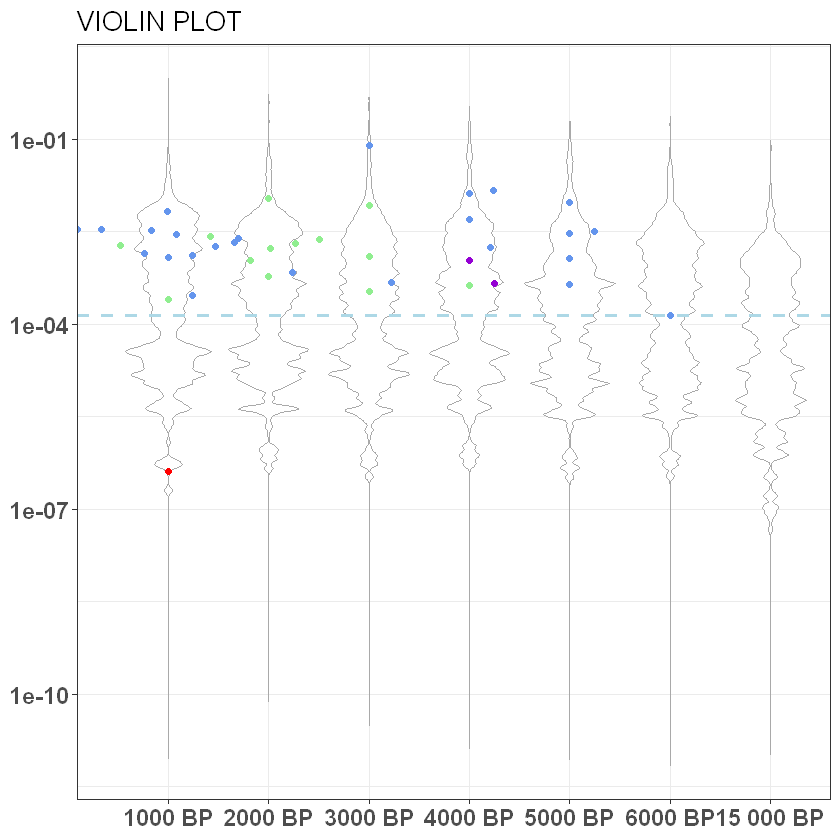

In [38]:
beeswarmv2

In [61]:
beeswarmb2<-ggplot()+
    geom_boxplot(data=d3, aes(x=Period, y=exp(Predictions)-1e-11),col="darkgrey")+
    geom_hline(aes(yintercept = exp(threshold),linetype="minimum predicted value\n for sites where buckwheat\nremains were found"),colour="lightblue",size=1)+
    geom_beeswarm(data=d1[d1$Site_section_name!="Kyung-lung Mesa/Kaerdong",], aes(x=period, y=exp(mean)-1e-11,colour=Sample_type),cex=2)+
    geom_beeswarm(data=d1[d1$Site_section_name=="Kyung-lung Mesa/Kaerdong",][1,], aes(x=period, y=exp(mean)-1e-11,fill="Site_section_name"),colour="red",cex=2)+
    scale_colour_manual(name="",values=c("lightgreen","cornflowerblue","darkviolet"))+
    scale_linetype_manual(name = "",values="dashed")+
    scale_fill_manual(name="",values="red",labels="F. tataricum\ncharred seed")+
    #scale_fill_manual(name="Sites with\nbuckwheat",values=c("darkgreen"),labels=c(""))+
    theme_bw()+
    scale_y_continuous(trans='log2',breaks=c(1e-10,1e-7,1e-4,1e-1))+
    #scale_fill_manual(name="Sites with\nbuckwheat",values=c("darkgreen"),labels=c(""))+
    labs(y = "PREDICTED VALUE\n(proportion of the area under buckehwat cultivation)\n",title="DISTRIBUTION OF ARCHAEOLOGICAL SITES WITH BUCKWEHAT REMAINS IN ENVIRONMENTAL SPACE")+
    theme_bw()+
    theme(axis.text.x = element_text(face="bold", size=14),
         axis.text.y = element_text(face="bold", size=14),
         axis.title.x=element_blank(),
         axis.title.y=element_blank(),
         plot.title = element_text(size=16),
         legend.position="bottom",
         legend.title = element_text(size = 16),
         legend.text = element_text(size = 13),
         legend.key.width = unit(2,"cm")) +
            guides(colour = guide_legend(override.aes = list(size=2)),
                   linetype = guide_legend(override.aes = list(size=1.5)))

In [62]:
png("outputs/boxplot.png", units="cm", width=width, height=height,res=300)
beeswarmb2
dev.off()

Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 2854 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1 rows containing missing values (position_beeswarm)."
Warning message in f(...):
"The default behavior of beeswarm has changed in version 0.6.0. In versions <0.6.0, this plot would have been dodged on the y-axis.  In versions >=0.6.0, grouponX=FALSE must be explicitly set to group on y-axis. Please set grouponX=TRUE/FALSE to avoid this warning and ensure proper axis choice."


png 
  2

Warning message:
"Removed 468 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1 rows containing missing values (position_beeswarm)."


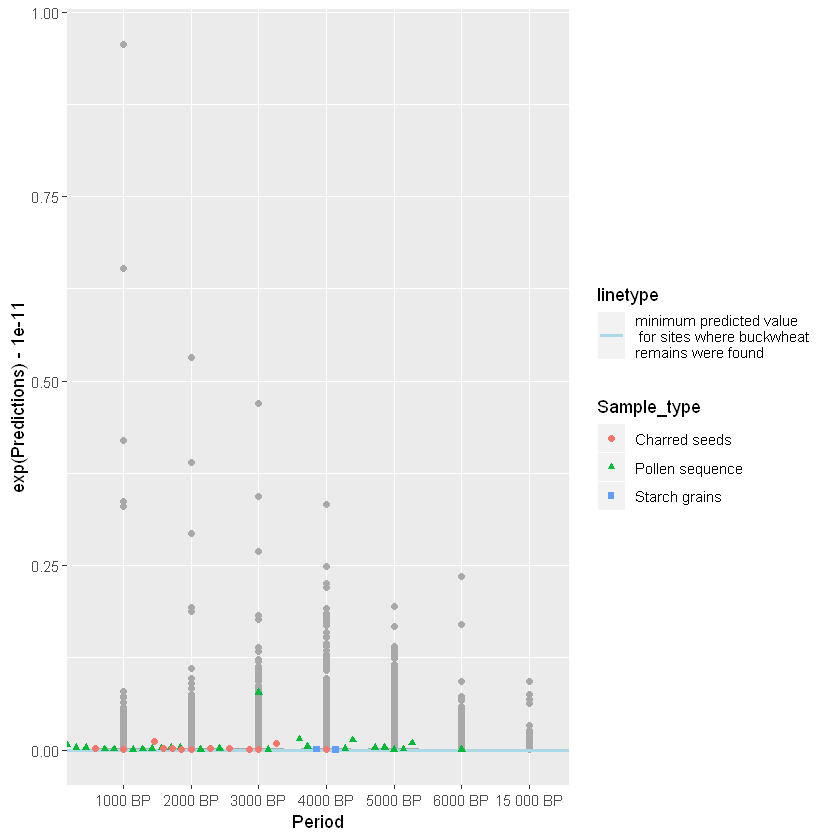

In [46]:
ggplot()+
    geom_boxplot(data=d3, aes(x=Period, y=exp(Predictions)-1e-11),col="darkgrey")+
    geom_hline(aes(yintercept = exp(threshold),linetype="minimum predicted value\n for sites where buckwheat\nremains were found"),colour="lightblue",size=1)+
    geom_beeswarm(data=d1[d1$Site_section_name!="Kyung-lung Mesa/Kaerdong",], aes(x=period, y=exp(mean)-1e-11,colour=Sample_type,pch=Sample_type),cex=2)

Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 2854 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1 rows containing missing values (position_beeswarm)."
Warning message in f(...):
"The default behavior of beeswarm has changed in version 0.6.0. In versions <0.6.0, this plot would have been dodged on the y-axis.  In versions >=0.6.0, grouponX=FALSE must be explicitly set to group on y-axis. Please set grouponX=TRUE/FALSE to avoid this warning and ensure proper axis choice."


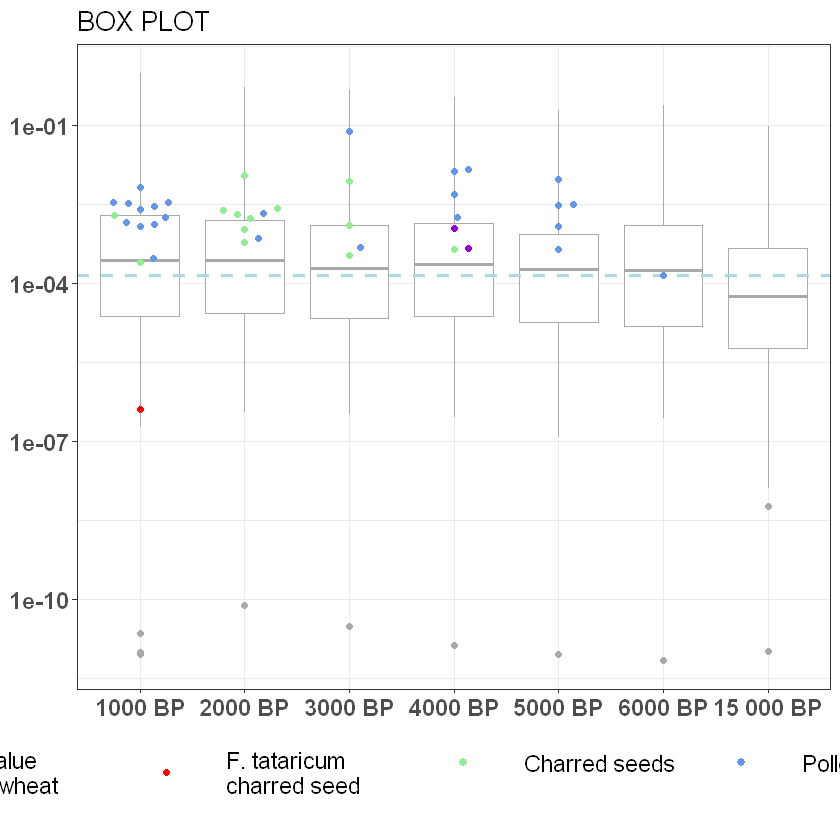

In [47]:
beeswarmb2

In [ ]:
bplots2<-ggarrange(beeswarmv2,beeswarmb2,ncol=1,nrow=2,common.legend=TRUE,legend="bottom")

In [ ]:
bplotsa2<-annotate_figure(bplots2,top=text_grob("Sutability of climatic conditions on sites with buckwheat remains, overlaid on the overall distribution of climatic\n conditions across China per time period (values per area equivalent to the smallest county in China)",face = "bold",size=19),
                                              left = text_grob("PREDICTED VALUE (proportion of the area under buckehwat cultivation)\n",size=16, rot = 90))

In [ ]:
bplotsa2

In [ ]:
ggsave(path2bplots_area,bplotsa2,width = 15, height = 15, units = "in",device='png')

In [57]:
### Get minimum predictions for each period
min_values<-data.frame()
periods<-unique(loc@data$period)
for(i in 1:6){
    print(i)
    k1<-loc@data[loc@data$period==periods[i],]
    min_value<-k1[which.min(k1$mean),c('mean','q5','q95')]
    min_values<-rbind(min_values,min_value)
    }
rownames(min_values) <-periods

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6


In [ ]:
write.csv(min_values,file=path2min)

In [ ]:
### add to data a new column termed "id" composed of the rownames of data
###Keep only the necessary columns:
d<-china
d@data<-means
d@data$id <- rownames(d@data)
d<-d[!is.na(d@data$means_pred_6k_log),] # check later what's up with NA values

In [ ]:
### Get polygon with mean value for each periods:
period_names<-colnames(d@data)
min_polygons <-list()
## This creates the boundary for the areas of suitable 
## Create this for each period:
for(i in 1:7){
    print(period_names[i])
a<-d[d@data[,period_names[i]]>min_values['6000 BP','mean'],]
a@data<-as.data.frame(a@data$id)
#### It should be this, but it takes a long time to process
p<-unionSpatialPolygons(a, rep(1,length(a)))
min_polygons[[i]] <- p
#metadata<-as.data.frame(rbind(c("6000 BP","mean")))
#colnames(metadata)<-c("Period","Interval")
#pdf<-SpatialPolygonsDataFrame(p,metadata)
    }
    

In [ ]:
min_polygons

In [ ]:
library(raster)
polygons <- do.call(bind, min_polygons) 

In [ ]:
loc@data$period

In [ ]:
pol_data<-as.data.frame(cbind(1:7,c("present",unique(loc@data$period))))
colnames(pol_data)<-c("id","period")

In [ ]:
pol = SpatialPolygonsDataFrame(polygons,data=pol_data)

In [ ]:
str(pol)

In [ ]:
predDF <- fortify(d, region = "id")
categories <- gather(d@data, category, predictions,mean_names[2:7])
predDF <- left_join(predDF, categories, by = "id")



In [ ]:
polDF <- fortify(pol, region = "id")

In [ ]:
head(polDF)

In [ ]:
polDF <- left_join(polDF,pol@data, by = "id")

In [ ]:
head(polDF)

In [ ]:
ggplot(data =polDF[polDF$id%in%2:7,],aes(x = long, y = lat,group=group)) + # define variables
geom_polygon(colour="black",fill="grey",alpha = 0.2)+  # plot the boroughs
facet_wrap(~period) 

In [ ]:
ggplot(data =pol,aes(x = long, y = lat,group=group)) + # define variables
geom_polygon(colour="black",fill="grey",alpha = 0.2)+  # plot the boroughs
facet_wrap(~id) 

In [ ]:
pol

In [ ]:
ggplot(data=min_polygons[[1]],aes(x = long, y = lat,group=group))+
geom_polygon(colour="black",fill="grey",alpha = 0.2)

In [ ]:
plot(min_polygons[[1]],border="red",lwd=3)
#plot(min_polygons[[2]],border="green",lwd=2.5)
#plot(min_polygons[[3]],border="blue",lwd=2)
#plot(min_polygons[[4]],border="yellow",add=TRUE,lwd=1.5)
#plot(min_polygons[[5]],border="purple", add=TRUE,lwd=1)
plot(min_polygons[[6]],border="grey",add=TRUE,lwd=0.5)
#plot(min_polygons[[7]],border="black",add=TRUE,lwd=0.25)

In [ ]:
min_polygons

In [ ]:
### Get polygon with mean value for each periods:
period_names<-colnames(d@data)
threshold_polygons <-list()
periods<-unique(loc@data$period)
periods <- c("0",periods)
## This creates the boundary for the areas of suitable 
## Create this for each period:
for(i in 2:7){
    print(period_names[i])
a<-d[d@data[,period_names[i]]>min_values[periods[i],'mean'],]
a@data<-as.data.frame(a@data$id)
#### It should be this, but it takes a long time to process
p<-unionSpatialPolygons(a, rep(1,length(a)))
threshold_polygons[[i-1]] <- p
#metadata<-as.data.frame(rbind(c("6000 BP","mean")))
#colnames(metadata)<-c("Period","Interval")
#pdf<-SpatialPolygonsDataFrame(p,metadata)
    }

In [ ]:
plot(threshold_polygons[[1]],border="red",lwd=3)
plot(threshold_polygons[[2]],add=TRUE,border="green",lwd=2.5)
plot(threshold_polygons[[3]],add=TRUE,border="blue",lwd=2)
plot(threshold_polygons[[4]],border="yellow",add=TRUE,lwd=1.5)
plot(threshold_polygons[[5]],border="purple", add=TRUE,lwd=1)
plot(threshold_polygons[[6]],border="grey",add=TRUE,lwd=0.5)

In [ ]:
### Merge polygon data:

pol2<-merge(SpatialPolygonsDataFrame(threshold_polygons[[1]]),SpatialPolygonsDataFrame(threshold_polygons[[2]]))

In [ ]:
metadata<-as.data.frame(rbind(c("6000 BP","mean",1)))
colnames(metadata)<-c("Period","Interval","id")
pdf<-SpatialPolygonsDataFrame(threshold_polygons[[6]],metadata)

In [ ]:
pdf2

In [ ]:
metadata<-as.data.frame(rbind(c("5000 BP","mean",2)))
colnames(metadata)<-c("Period","Interval","ID")
pdf2<-SpatialPolygonsDataFrame(threshold_polygons[[5]],metadata)

In [ ]:
pol3<-SpatialPolygonsDataFrame(c(threshold_polygons[[5]],threshold_polygons[[5]]),pol2@data)

In [ ]:
str(pdf@polygons)


In [ ]:
 h<-spRbind(pdf,pdf2)

In [ ]:
pdf

In [ ]:
#### GGplot polygons:
difference<-ggplot() + 
geom_polygon(data=min_polygons[[1]],aes(x = long, y = lat))+
coord_equal()+
labs(title ="Difference between the mean predictions\nand the observed value")+
theme(
  panel.background = element_rect(fill = NA),
  panel.grid.major = element_line(colour = "lightgrey"),
  strip.background = element_rect(fill=NA),
  legend.key.height=unit(0.5,"cm"),
  text = element_text(family = "sans"), 
  axis.text=element_text(size=10),
  plot.title = element_text(hjust = 0.5,size=8))+
scale_fill_gradient2(low = "blue", mid="yellow", high = "red")
difference

In [ ]:
## This creates the boundary for the areas of suitable 
## Create this for each period:
a<-d[d@data$means_pred_6k_log>min_values['6000 BP','mean'],]
a@data<-as.data.frame(a@data$id)
#### It should be this, but it takes a long time to process
p<-unionSpatialPolygons(a, rep(1,length(a)))
metadata<-as.data.frame(rbind(c("6000 BP","mean")))
colnames(metadata)<-c("Period","Interval")
#pdf<-SpatialPolygonsDataFrame(p,metadata)

In [ ]:
pdf<-SpatialPolygonsDataFrame(p,metadata)

In [ ]:
cbind(pdf,pdf)

In [ ]:
b<-unionSpatialPolygons(a, rep(1,length@data$id))

In [ ]:
plot(b)

In [ ]:
str(a)

In [ ]:
colnames(d@data)

In [ ]:
min_values<-data.frame()

rbind(min_values,min_value)

In [ ]:
k1[which.min(k1$mean),c('mean','q5','q95')]

In [ ]:
loc@data$mean<-NA
loc@data$q5<-NA
loc@data$q95<-NA


In [ ]:
loc@data[grep("1",loc@data$period),c(mean,q5,q95)]

In [ ]:
loc@data[grep(as.character(i),loc@data$period),c('mean','q5','q95')]<-loc@data[grep(as.character(i),loc@data$period),grep(paste(i,"k",sep=""),colnames(loc@data))]

In [ ]:
loc@data[grep(as.character(i),loc@data$period),c('mean','q5','q95')]<-loc@data[grep("1",loc@data$period),grep("1k",colnames(loc@data))]

In [ ]:
loc@data


In [ ]:
loc@data$period

In [ ]:
library(sp)

In [ ]:
plot(pred)
points(loc,col="red",pch=16)

### Present:

In [ ]:
### add to data a new column termed "id" composed of the rownames of data
###Keep only the necessary columns:
d<-china
d@data<-means
d@data$id <- rownames(d@data)

In [ ]:
predDF <- fortify(d, region = "id")
categories <- gather(d@data, category, predictions,mean_names[2:7])
predDF <- left_join(predDF, categories, by = "id")

In [ ]:
mean_pred<-ggplot(predDF, aes(x = long, y = lat,group=group,fill=predictions)) + 
geom_polygon(aes(x = long, y = lat))+
facet_wrap(~category,nrow = 3, ncol = 2)+
#scale_fill_gradient2(low = "darkblue", high = "indianred", mid="lightyellow")+
#scale_color_brewer(palette = "RdYlBu")+
scale_fill_gradientn(colours = rev(brewer.pal(8, "RdBu")))+
coord_equal()+
theme(
  panel.background = element_rect(fill = NA),
  panel.grid.major = element_line(colour = "lightgrey"),
  strip.background = element_rect(fill=NA)
)
mean_pred

In [ ]:
ggsave(path2predictions_plots,posterior_pred,width = saved$repr.plot.width, height = saved$repr.plot.height, units = "in",device='png')

# Future manual:

In [61]:
s2<-c('mns__1_','mns__2_','mns__3_','mns__4_','mns__5_','mns__6_')

In [62]:
head(china@data)
d<-china

,ID_0,ISO,NAME_,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,TYPE_3,...,mns__5_,X5._5k,X95._5k,mns_p_5,X5._6k_l,X95._6k_,mns__6_,X5._6k,X95._6k,mns_p_6
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,49,CHN,China,1,Anhui,1,Anqing,1,Anqing,XiÃ njÃ­shÃ¬,...,-8.785086,5.070033e-05,0.0004613292,0.0001529979,-9.173789,-6.817093,-7.995996,1.037228e-04,1.094899e-03,0.0003368085
1,49,CHN,China,1,Anhui,1,Anqing,2,Huaining,XiÃ n,...,-8.798354,5.005099e-05,0.0004577205,0.0001509814,-11.551926,-9.268541,-10.418492,9.617506e-06,9.434602e-05,0.0000298749
2,49,CHN,China,1,Anhui,1,Anqing,3,Qianshan,XiÃ n,...,-8.695061,5.156189e-05,0.0005420143,0.0001674106,-10.129596,-8.051635,-9.093334,3.988158e-05,3.185805e-04,0.0001124127
3,49,CHN,China,1,Anhui,1,Anqing,4,Susong,XiÃ n,...,-8.960643,3.921362e-05,0.0004196374,0.0001283637,-9.361181,-6.968997,-8.162584,8.599846e-05,9.405961e-04,0.0002851246
4,49,CHN,China,1,Anhui,1,Anqing,5,Taihu,XiÃ n,...,-8.821128,4.997772e-05,0.0004350025,0.0001475818,-9.338636,-7.207656,-8.270017,8.795929e-05,7.408920e-04,0.0002560809
5,49,CHN,China,1,Anhui,1,Anqing,6,Tongcheng,XiÃ njÃ­shÃ¬,...,-8.150502,9.141441e-05,0.0009165616,0.0002885905,-9.529046,-7.533612,-8.535003,7.270894e-05,5.348031e-04,0.0001964695


In [63]:
d@data$id <- rownames(d@data)
predDF <- fortify(d, region = "id")
# gather data by category
#categories <- gather(china@data, category, predictions, s2)
# merge the "fortified" data with the data from our spatial object
#predDF <- left_join(predDF, categories, by = "id")

In [64]:
categories <- gather(d@data, category, predictions, s2)
# merge the "fortified" data with the data from our spatial object
predDF <- left_join(predDF, categories, by = "id")

In [ ]:
ggplot(data =pol,aes(x = long, y = lat,group=group)) + # define variables
geom_polygon(data =pol,aes(x = long, y = lat,group=group),colour="black",fill="grey",alpha = 0.2)+  # plot the boroughs
facet_wrap(~id) 

In [ ]:
categories <- gather(china@data, category, predictions, AreaPr,s2)
predDF1 <- left_join(predDF, categories, by = "id")

In [65]:
library(RColorBrewer)

In [ ]:
head(pol$category)

In [ ]:
head(pol@data)

In [73]:
head(pol$df)

NULL

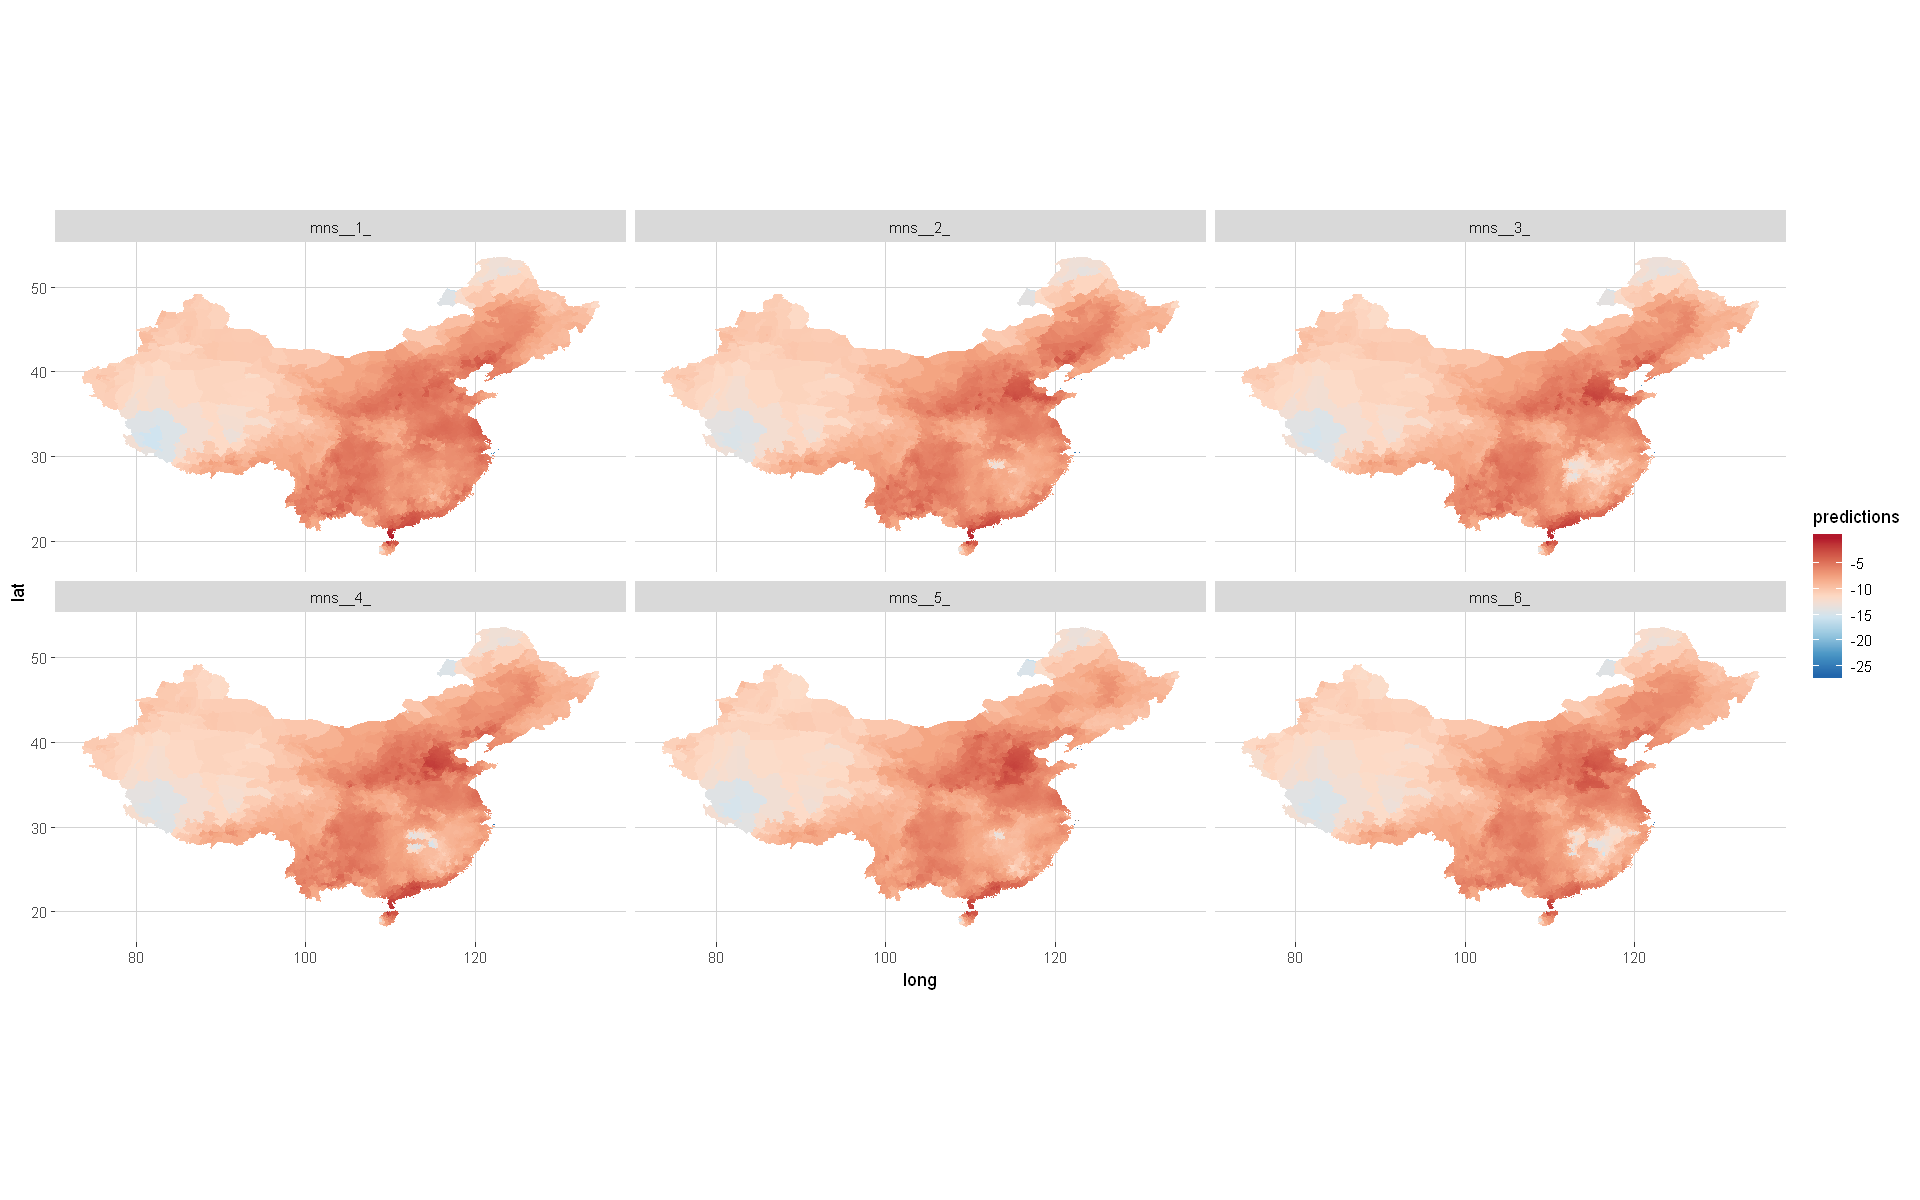

In [72]:
saved <- options(repr.plot.width=16, repr.plot.height=10)
saved$repr.plot.width <- 16
saved$repr.plot.height<-10
posterior_pred<-ggplot() + 
geom_polygon(data=predDF, aes(x = long, y = lat,group=group,fill=predictions))+
#geom_polygon(data=polDF,aes(x = long, y = lat,group=group),fill="grey",alpha = 0.2,colour="black")+
facet_wrap(~category)+
#scale_fill_gradient(low = "lightyellow", high = "red")+
scale_fill_gradientn(colours = rev(brewer.pal(8, "RdBu")))+
coord_equal()+
theme(
  panel.background = element_rect(fill = NA),
  panel.grid.major = element_line(colour = "lightgrey"),
)
posterior_pred

In [ ]:
pol()

In [ ]:
ggsave(path2means,posterior_pred,width = saved$repr.plot.width, height = saved$repr.plot.height, units = "in",device='png')

In [ ]:
s2<-c('mns__1_','mns__2_','mns__3_','mns__4_','mns__5_','mns__6_')

1. Boxplot, per period, blox 1000 years, sites with multiple occupations counted multiple times
2. Maps with lowest threshold for each period + confidence interval (minimum production) - geographical explansion.
3. Map with thresholds for different periods (aggregation)
4. Plot the counties with predictions not matching
5. Use WAIC to decide model comparison

### Plot data using sp package:


In [ ]:
china

In [ ]:
plot(counties, col='light gray', border='gray')
plot(yolo, add=TRUE, density=20, lwd=2, col='red')

In [ ]:
sb1<-as_Spatial(st_union(china_sf[china_sf$pred1k>=threshold,]))
sb1<-SpatialPolygonsDataFrame(sb1,data=data.frame(id=1,period="1000 BP",row.names=row.names(sb1)))

sb2<-as_Spatial(st_union(china_sf[china_sf$pred2k>=threshold,]))
sb2<-SpatialPolygonsDataFrame(sb2,data=data.frame(id=2,period="2000 BP",row.names=row.names(sb2)))

sb3<-as_Spatial(st_union(china_sf[china_sf$pred3k>=threshold,]))
sb3<-SpatialPolygonsDataFrame(sb3,data=data.frame(id=3,period="3000 BP",row.names=row.names(sb3)))

sb4<-as_Spatial(st_union(china_sf[china_sf$pred4k>=threshold,]))
sb4<-SpatialPolygonsDataFrame(sb4,data=data.frame(id=4,period="4000 BP",row.names=row.names(sb4)))

sb5<-as_Spatial(st_union(china_sf[china_sf$pred5k>=threshold,]))
sb5<-SpatialPolygonsDataFrame(sb5,data=data.frame(id=5,period="5000 BP",row.names=row.names(sb5)))

sb6<-as_Spatial(st_union(china_sf[china_sf$pred6k>=threshold,]))
sb6<-SpatialPolygonsDataFrame(sb6,data=data.frame(id=6,period="6000 BP",row.names=row.names(sb6)))